In [1]:
!pip install squarify
!pip install matplotlib==3.1.3
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp39-cp39-linux_x86_64.whl size=12062456 sha256=fdabd85637d747a173659ef48d9c7f83d16eaa8afc7b74616d07e8303f5122c0
  Stored in directory: /root/.cache/pip/wheels/88/5f/33/d7b8943eba74fdfbd535c83cefcf366c25b0f9cb6424e763e7
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matpl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd '/content/gdrive/MyDrive/Thư mục không có tiêu đề/Project3_improved/P3_Customer_Segmentation/Data_&_Workbook/'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Thư mục không có tiêu đề/Project3_improved/P3_Customer_Segmentation/Data_&_Workbook


# RFM Segmentation

In [4]:
rfm_df = pd.read_csv('Data/RFM_data.csv')

In [5]:
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M
0,545,1,11.77,1,1,1
1,534,1,89.00,1,1,3
2,33,6,156.46,4,4,4
3,200,4,100.50,4,4,3
4,178,11,385.61,4,4,4


In [6]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23446 entries, 0 to 23445
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    23446 non-null  int64  
 1   Frequency  23446 non-null  int64  
 2   Monetary   23446 non-null  float64
 3   R          23446 non-null  int64  
 4   F          23446 non-null  int64  
 5   M          23446 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 1.1 MB


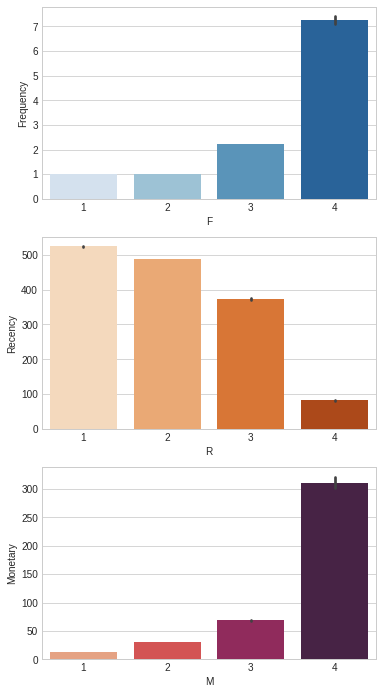

In [7]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (6,12))
plt.subplot(3,1,1)
sns.barplot(data = rfm_df, y='Frequency', x='F',palette='Blues')
plt.subplot(3,1,2)
sns.barplot(data = rfm_df, y='Recency', x='R',palette='Oranges')
plt.subplot(3,1,3)
sns.barplot(data = rfm_df, y='Monetary', x='M',palette='rocket_r')
plt.show();

## Thực hiện gán nhãn cho từng khách hàng
- Recency : 3 nhóm
  - 1 & 2 : gần 2 năm chưa mua hàng
  - 3 : 1 năm chưa mua hàng
  - 4 : mua cách đây vài tháng
- Frequency : 3 nhóm
  - 1 & 2 & 3 : những khách hiếm khi mua (<= 3 lần)
  - 4 : những khách thường xuyên mua (> 7 lần)
- Monetary : 2 nhóm
  - 1 & 2 & 3 : khách tạo ra ít doanh thu (<= 75$)

  - 4 : khách mang lại nhiều doanh thu (> 275$)
---

R(1/2) + F(1/2/3/4) + M(1/2/3/4) :  Left - khách gần 2 năm chưa mua hàng

R(3/4) + F(1/2/3) + M(1/2/3/4) : Regular - 1 năm chưa mua hoặc vừa mua, tần suất mua thấp.

R(3) + F(4) + M(4) :  Leaving - 1 năm chưa mua, thường xuyên mua, doanh thu/giao dịch cao

R(4) + F(4) + M(4) : Loyal - vừa mua, tần suất mua cao, chi tiêu/giao dịch tốt


In [8]:
def rfm_label(df):
  if df.R == 1 or df.R == 2:
    return "Left"
  elif (df.R == 3 or df.R == 4) and df.F != 4:
    return "Regular"
  elif (df.R == 3) and df.F == 4 and df.M == 4:
    return "Leaving"
  else:
    return "Loyal"

rfm_df['RFM_label'] = rfm_df.apply(rfm_label, axis=1)

In [9]:
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFM_label
0,545,1,11.77,1,1,1,Left
1,534,1,89.00,1,1,3,Left
2,33,6,156.46,4,4,4,Loyal
3,200,4,100.50,4,4,3,Loyal
4,178,11,385.61,4,4,4,Loyal


In [10]:
rfm_df['RFM_label'].value_counts()

Left       11723
Regular     5907
Loyal       4826
Leaving      990
Name: RFM_label, dtype: int64

In [11]:
def qua_rev_plot(df, label, palette):
  count = df[label].value_counts(normalize=True)*100
  sum = df[['Monetary',label]].groupby(label).sum()
  sum['percent'] = round(sum['Monetary']*100/df.Monetary.sum(),2)

  plt.figure(figsize = (10, 5))
  # clusters by quantity
  plt.subplot(1,2,1)
  ax_q = sns.barplot(data = count, 
              x = count.index.tolist(), y = count.values,
              orient = 'h',
              palette = palette)
  ytick = [str(x) for x in count.sort_values().index.tolist()]
  ax_q.set_yticklabels(ytick, fontsize=13)
  plt.setp(ax_q.get_xticklabels(), fontsize = 13)
  ax_q.set_title("Customers' count by each cluster (%)", fontsize=17)
  ax_q.set_ylabel('Labels', fontsize = 15)
  ax_q.set_xlabel(None)
  # clusters by revenues
  plt.subplot(1,2,2)
  ax_r = sns.barplot(y = sum.sort_values(by='percent').index, 
              x=sum.sort_values(by='percent').percent, 
              palette = palette, orient='h')
  ytick = [str(x) for x in sum.sort_values(by='percent').index.values.tolist()]
  ax_r.set_yticklabels(ytick, fontsize = 13)
  ax_r.set_xlim(0, 60)
  ax_r.set_ylabel(None)
  ax_r.set_xlabel(None)
  ax_r.set_title('Total revenue by customer clusters (%)', fontsize = 17)
  plt.setp(ax_r.get_xticklabels(), fontsize=13)
  plt.tight_layout()
  plt.show();

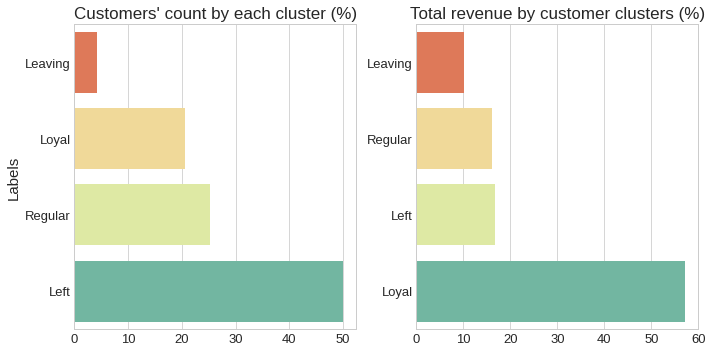

In [12]:
  qua_rev_plot(rfm_df, label = 'RFM_label', palette = 'Spectral')

- Left : Dữ liệu cho thấy đã gần 1.5 năm nhóm này chưa thực hiện việc mua hàng tại công ty. Đây là nhóm chiếm tỷ lệ đông nhất trong tập dữ liệu nhưng lại tỷ lệ doanh thu đóng góp tương đối thấp (15%). Nhóm này cũng cho thấy tần suất mua thấp (trung bình chỉ thực hiện mua 1 lần) và chi tiêu/giao dịch cũng thấp (trung bình $35/giao dịch)

- Regular : Đây là nhóm khách hàng có số lượng chiếm 20% tập dữ liệu với đóng góp họ vào tổng doanh thu là 15% (ngang bằng với nhóm Left). Nhóm này cũng cho thấy khoảng cách thời gian mua lớn (trung bình gần 1 năm chưa thực hiện mua lại), với tần suất thấp (trung bình 2 lần mua) và chi tiêu/giao dịch nhỏ (trung bình $68).

- Leaving : Đây là nhóm khách hàng khá tiềm năng với tần suất mua tốt (trung bình 6 lần mua hàng), và chi tiêu/giao dịch cao (trunh bình $256). Tuy vậy nhóm này đang cho thấy hành vì rời bỏ doanh nghiệp khi trung bình đã gần 300 ngày họ chưa thực hiện mua lại. Doanh nghiệp cần có các đối sách marketing nhằm giữ chân nhóm khách hàng tiềm năng này.

- Loyal : Đây là nhóm mang lại nhiều doanh thu nhất cho công ty (gần 60% tổng doanh thu) trong khi số lượng khách hàng chỉ chiếm 20% tổng quan sát. Đây cũng là nhóm có hành vi mua hàng tốt nhất với tần sất mua tốt (trung bình 8 lần), doanh thu/giao dịch cao (trung bình $295).

In [13]:
# tính trung bình va phần trăm của mỗi nhóm khách hàng
rfm_agg = rfm_df.groupby('RFM_label').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
rfm_agg['Percent'] = round(rfm_agg['Count']*100/rfm_agg.Count.sum(), 2)

rfm_agg = rfm_agg.reset_index()

In [14]:
rfm_agg

,RFM_label,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Leaving,308.0,6.0,256.0,990,4.22
1,Left,506.0,1.0,35.0,11723,50.00
2,Loyal,103.0,8.0,295.0,4826,20.58
3,Regular,317.0,2.0,68.0,5907,25.19


## Treemap


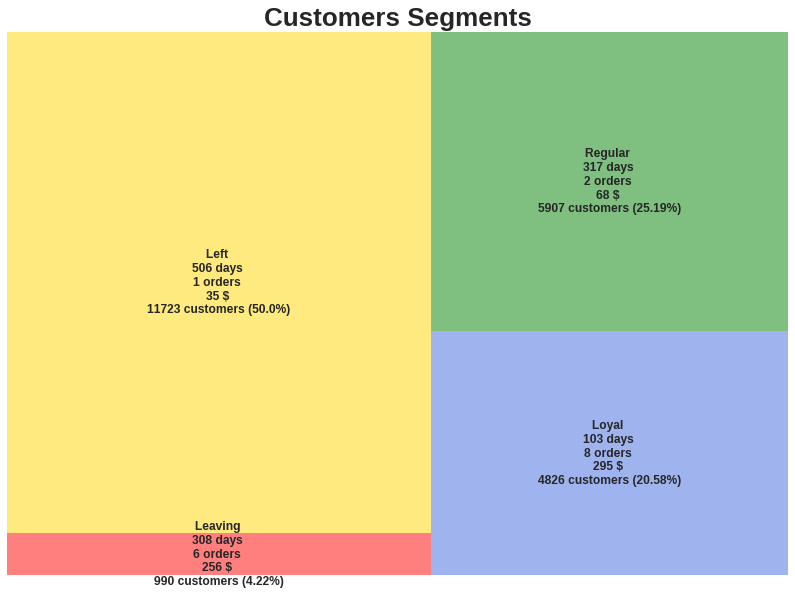

In [15]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14,10)

colors_dict = {'Lost':'red', 'Loyal':'gold', 'Leaving':'royalblue', 'Regular' : 'green'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':12,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

#plt.savefig('Workbooks/RFM_img/RFM_TreeSegments.png', dpi=300)
plt.show()

## Bubble plot

In [16]:
# Bubble plot
colors_dict = {'Lost':'red', 'Loyal':'gold', 'Leaving':'royalblue', 'Regular' : 'green'}

fig = px.scatter(rfm_agg, x="RecencyMean", y="FrequencyMean", size="MonetaryMean", color="RFM_label",
           hover_name="RFM_label", size_max=100)
fig.show()


## Scatter plot

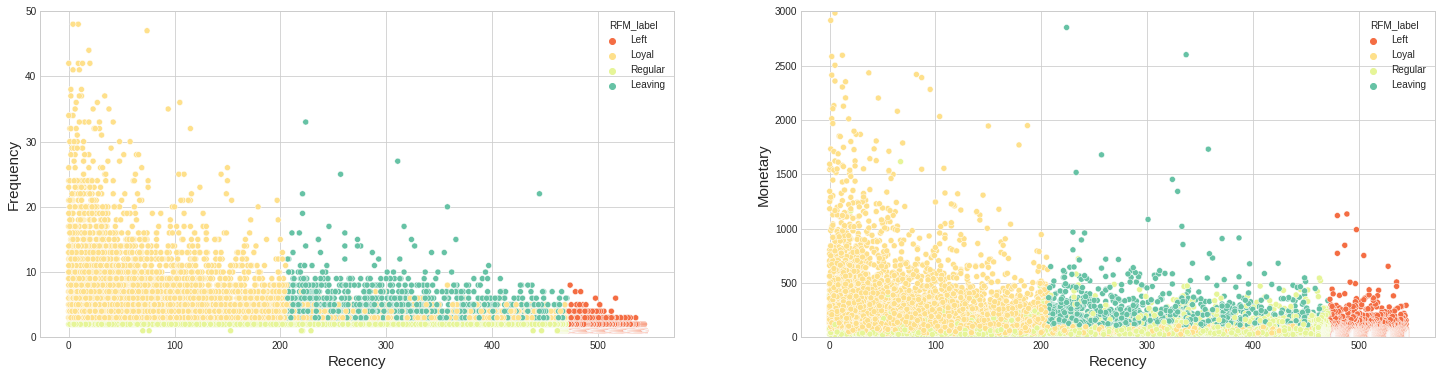

In [17]:
fig = plt.figure(figsize = (25, 6))
plt.subplot(1,2,1)
sns.scatterplot(data = rfm_df, x = 'Recency', y = 'Frequency', hue='RFM_label', palette = 'Spectral')
plt.ylim([0, 50])
plt.xlabel('Recency', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.subplot(1,2,2)
sns.scatterplot(data = rfm_df, x = 'Recency', y = 'Monetary', hue='RFM_label', palette = 'Spectral')
plt.ylim([0, 3000])
plt.xlabel('Recency', fontsize = 15)
plt.ylabel('Monetary', fontsize = 15)
plt.show();

# fig.savefig('Workbooks/RFM_img/RFM_ScatterSegment.png', dpi = 300, bbox_inches='tight')

### 3d Scatter Plot (RFM)

In [18]:
fig = px.scatter_3d(rfm_df, x='Recency', y='Frequency', z='Monetary',
                    color = 'RFM_label', opacity=0.5,
                    color_discrete_map = colors_dict)
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='markers'))
fig.show()

---
# Sklearn Models

## Kmeans Clustering

In [19]:
df = rfm_df[['Recency', 'Frequency', 'Monetary']]

In [20]:
df.head()

,Recency,Frequency,Monetary
0,545,1,11.77
1,534,1,89.00
2,33,6,156.46
3,200,4,100.50
4,178,11,385.61


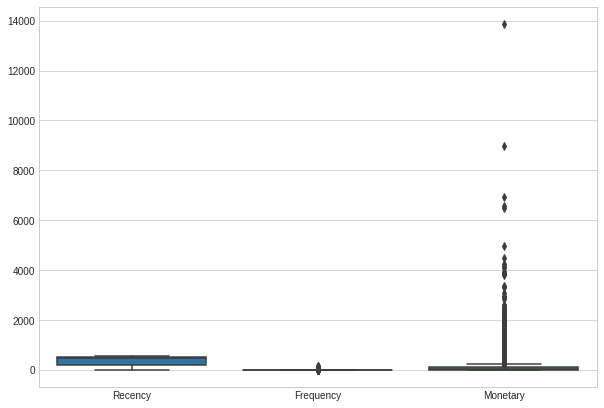

In [21]:
# xem outliners
plt.figure(figsize=(10, 7))
sns.boxplot(data=df)
plt.show();

In [22]:
# scale data
from sklearn import preprocessing
def scale_data(df):
  log_features = df.copy()
  log_features['R_log'] = np.log1p(log_features['Recency'])
  log_features['F_log'] = np.log1p(log_features['Frequency'])
  log_features['M_log'] = np.log1p(log_features['Monetary'])
  col_names = ['R_log', 'F_log','M_log']
  log_df = log_features[col_names]
  
  robust_scaler = preprocessing.RobustScaler()
  scaled = robust_scaler.fit_transform(log_df)
  scale_df = pd.DataFrame(scaled, columns=df[['Recency', 'Frequency', 'Monetary']].columns.values.tolist())
  return scale_df

scale_df = scale_data(rfm_df)

In [23]:
scale_df.head()

,Recency,Frequency,Monetary
0,0.163825,0.000000,-0.763866
1,0.140931,0.000000,0.430316
2,-2.959081,1.807355,0.772394
3,-0.960265,1.321928,0.503854
4,-1.090658,2.584963,1.321716


In [24]:
def dis_box_plot(df):
  dis_box_fig = plt.figure(figsize=(10,8))
  plt.subplot(3, 2, 1)
  sns.distplot(df['Recency'], color = 'c')
  plt.subplot(3, 2, 3)
  sns.distplot(df['Frequency'], color = 'c')
  plt.subplot(3, 2, 5)
  sns.distplot(df['Monetary'], color = 'c') 
  plt.subplot(3, 2, 2)
  sns.boxplot(df.Recency, color = 'c', orient = 'h')
  plt.xlabel('Recency')
  plt.subplot(3, 2, 4)
  sns.boxplot(df.Frequency, color = 'c', orient = 'h')
  plt.xlabel('Frequency')
  plt.subplot(3, 2, 6)
  sns.boxplot(df.Monetary, color = 'c', orient = 'h')
  plt.xlabel('Monetary Value')
  plt.tight_layout()
  return dis_box_fig

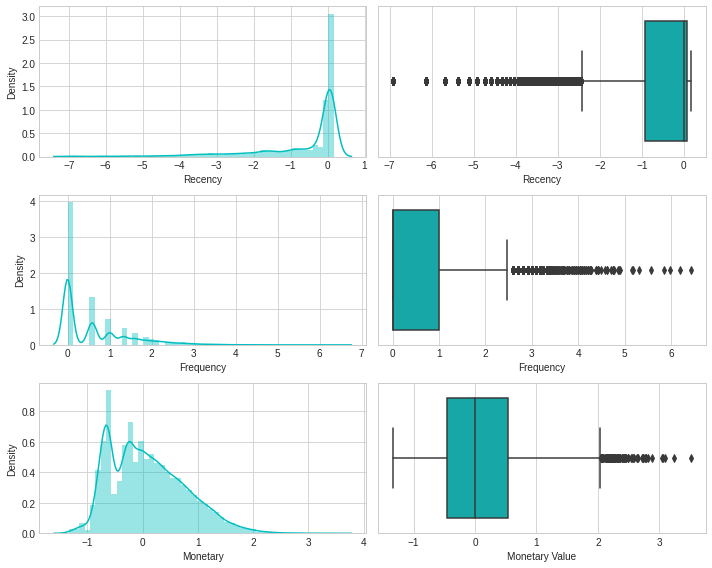

In [25]:
fig = dis_box_plot(scale_df)
fig.show();

### Xác định number of clusters (k)


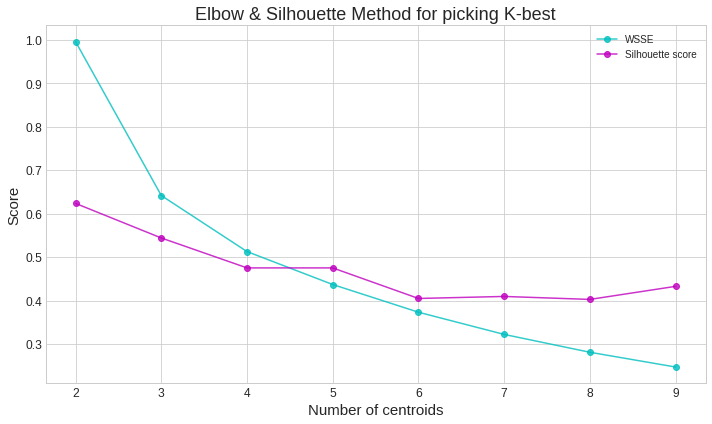

In [26]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Elbow method
wsse = []
K=[]
silhouette = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scale_df)
    wsse.append(kmeans.inertia_/scale_df.shape[0])
    silhouette.append(silhouette_score(scale_df, kmeans.labels_))
    K.append(k)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(K, wsse, c = 'c', marker = 'o', alpha = 0.8, label = 'WSSE')
plt.plot(K, silhouette, c = 'm', marker = 'o', alpha = 0.8, label = 'Silhouette score')
plt.xlabel('Number of centroids', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.xticks(K, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.title('Elbow & Silhouette Method for picking K-best', fontsize = 18)

plt.tight_layout()
plt.show();

#### Dựa vào kết quả của hai phương pháp, ta chọn k-cluster = 5

In [27]:
# Train model
model = KMeans(n_clusters = 5)
model.fit(scale_df)

# get centroids and labels
centroids = model.cluster_centers_
K_labels = model.labels_

df['K_label'] = pd.Series(K_labels)

In [28]:
df.head()

,Recency,Frequency,Monetary,K_label
0,545,1,11.77,2
1,534,1,89.00,2
2,33,6,156.46,4
3,200,4,100.50,0
4,178,11,385.61,3


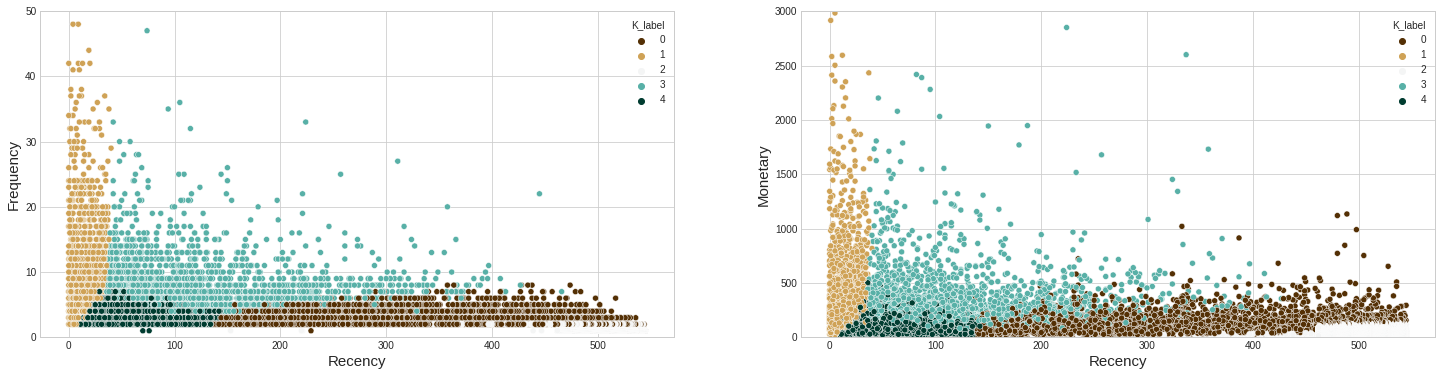

In [29]:
fig = plt.figure(figsize = (25, 6))
plt.subplot(1,2,1)
sns.scatterplot(data = df, x = 'Recency', y = 'Frequency', hue='K_label', palette = 'BrBG')
plt.ylim([0, 50])
plt.xlabel('Recency', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.subplot(1,2,2)
sns.scatterplot(data = df, x = 'Recency', y = 'Monetary', hue='K_label', palette = 'BrBG')
plt.ylim([0, 3000])
plt.xlabel('Recency', fontsize = 15)
plt.ylabel('Monetary', fontsize = 15)
plt.show();

In [30]:
# Bubble plot
df_agg =df.groupby('K_label').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']}).round(0)

df_agg.columns = df_agg.columns.droplevel()
df_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
df_agg['Percent'] = round(rfm_agg['Count']*100/rfm_agg.Count.sum(), 2)

df_agg = df_agg.reset_index()

fig = px.scatter(df_agg, x="RecencyMean", y="FrequencyMean", size="MonetaryMean", color="K_label",
           hover_name="K_label", size_max=100)
fig.show()

In [31]:
df_agg

,K_label,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,0,345.0,3.0,105.0,5343,4.22
1,1,15.0,11.0,479.0,1325,50.00
2,2,499.0,1.0,28.0,12682,20.58
3,3,131.0,8.0,356.0,2029,25.19
4,4,72.0,3.0,104.0,2067,NaN


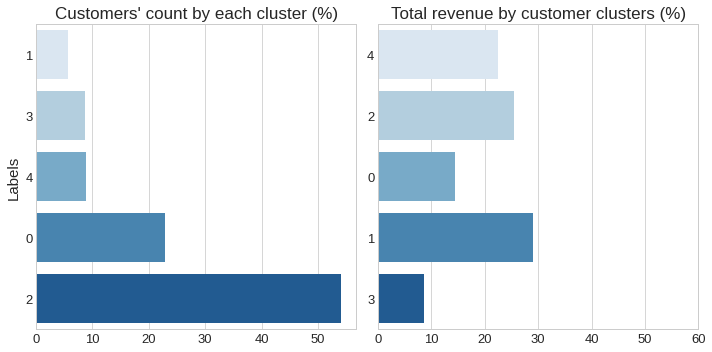

In [32]:
qua_rev_plot(df, label = 'K_label', palette = 'Blues')

### Nhận xét:
- (0) và (4): hai clusters cho thấy chỉ có sự khác biệt đáng kể về recency với (0) là gần 2 tháng và (4) là gần 1 năm => Có thể gộp hai nhóm này thành một vì họ không cho thấy sự gắn bó tốt với doanh nghiệp do có Frequency thấp, đồng thời chi tiêu/giao dịch của họ cũng không quá cao. => *Regular group*
- (1) : đây là nhóm có chi tiêu/giao dịch thấp, tần suất mua thấp và đã 1.5 năm họ chưa thực hiện mua lại. Họ là nhóm walk-in và đã không còn mua hàng tại doanh nghiệp nữa => *Left group*
- (2) : đây là những khách hàng tiềm năng với chi tiêu/giao dịch và tần suất mua tốt. Họ cũng là nhóm đóng góp hơn 20% tổng doanh thu và đang có dấu hiệu rời bỏ vì đã gần 4 tháng chưa thực hiện giao dịch. Đây là nhóm cần được chăm sóc và kích cầu tiêu dùng => *Potential group*
- (3) : đây là nhóm khách hàng có giá trị nhất với chi tiêu/giao dịch cao, tần suất mua tốt và vẫn còn duy trì thói quen tiêu dùng đối với doanh nghiệp. Họ cũng là nhóm cần được đặc biệt chú trọng vì mặc dù chỉ chiếm 5% tập dữ liệu nhưng có đóng góp gần 30% tổng doanh thu => *Star group*

In [33]:
# gán lại nhãn cho kmeans
def labeling(df):
  if df['K_label'] == 1:
    return "Left"
  elif df['K_label'] == 2:
    return "Potential"
  elif df['K_label'] == 3:
    return "Star"
  else:
    return "Regular"

k_df = df.copy()
k_df['label'] = k_df.apply(labeling, axis = 1)

In [34]:
k_df.head()

,Recency,Frequency,Monetary,K_label,label
0,545,1,11.77,2,Potential
1,534,1,89.00,2,Potential
2,33,6,156.46,4,Regular
3,200,4,100.50,0,Regular
4,178,11,385.61,3,Star


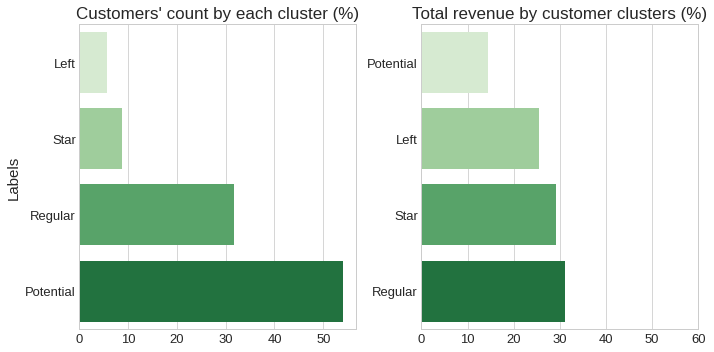

In [35]:
qua_rev_plot(k_df, label = 'label', palette = 'Greens')

## Hierarchical Clustering

In [36]:
import scipy.cluster.hierarchy as sch


plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10, 8))
dendrogram = sch.dendrogram(sch.linkage(scale_df, method = 'ward'))
plt.title('Dendogram', fontsize = 15)
plt.show();

KeyboardInterrupt: ignored

<Figure size 720x576 with 0 Axes>

In [ ]:
# dựa trên dendrogram ta chọn k = 5

from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
model.fit(scale_df)

# get labels
H_label = model.labels_

df['H_label'] = pd.Series(H_label)

In [ ]:
df.head()

In [ ]:
# Bubble plot
df_agg =df.groupby('H_label').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : ['mean', 'count']}).round(0)

df_agg.columns = df_agg.columns.droplevel()
df_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
df_agg['Percent'] = round(rfm_agg['Count']*100/rfm_agg.Count.sum(), 2)

df_agg = df_agg.reset_index()

fig = px.scatter(df_agg, x="RecencyMean", y="FrequencyMean", size="MonetaryMean", color="H_label",
           hover_name="H_label", size_max=100)
fig.show()

Hierarchical Clustering cho kết quả tương tự với Kmeans

--- 
# Classification model dựa trên Kmeans model và RFM analysis

In [37]:
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFM_label
0,545,1,11.77,1,1,1,Left
1,534,1,89.00,1,1,3,Left
2,33,6,156.46,4,4,4,Loyal
3,200,4,100.50,4,4,3,Loyal
4,178,11,385.61,4,4,4,Loyal


In [38]:
rfm_df['RFM_label'].value_counts()

Left       11723
Regular     5907
Loyal       4826
Leaving      990
Name: RFM_label, dtype: int64

In [39]:
k_df.head()

,Recency,Frequency,Monetary,K_label,label
0,545,1,11.77,2,Potential
1,534,1,89.00,2,Potential
2,33,6,156.46,4,Regular
3,200,4,100.50,0,Regular
4,178,11,385.61,3,Star


In [40]:
k_df['label'].value_counts()

Potential    12682
Regular       7410
Star          2029
Left          1325
Name: label, dtype: int64

In [41]:
# label encoding
def encoding(df):
  if df == 'Left':
    return 1
  elif df == 'Regular':
    return 2
  elif df == 'Leaving' or df == 'Potential':
    return 3
  else:
    return 4
  
rfm_df['encode_label'] = rfm_df['RFM_label'].apply(encoding)
k_df['encode_label'] = k_df['label'].apply(encoding)

In [42]:
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFM_label,encode_label
0,545,1,11.77,1,1,1,Left,1
1,534,1,89.00,1,1,3,Left,1
2,33,6,156.46,4,4,4,Loyal,4
3,200,4,100.50,4,4,3,Loyal,4
4,178,11,385.61,4,4,4,Loyal,4


In [43]:
k_df.head()

,Recency,Frequency,Monetary,K_label,label,encode_label
0,545,1,11.77,2,Potential,3
1,534,1,89.00,2,Potential,3
2,33,6,156.46,4,Regular,2
3,200,4,100.50,0,Regular,2
4,178,11,385.61,3,Star,4


In [44]:
# RFM clusers data split
x1 = rfm_df.iloc[:, :3]
y1 = rfm_df.iloc[:, -1]

# Kmeans clusers data split
x2 = k_df.iloc[:, :3]
y2 = k_df.iloc[:, -1]

In [45]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings('ignore')

# Liệt kê các model sử dụng
models = [LogisticRegression(), GaussianNB(), KNeighborsClassifier(n_neighbors=11), 
          DecisionTreeClassifier(), RandomForestClassifier(), SVC()]
scores_1 = []
scores_2 = []
train_times = []
names = []

# Duyệt qua các model
    # Thực hiện cross_val_score (k-fold) với mỗi model (cv=10)
    # Thêm số liệu cho socres, train_times, names
for model in models:
    start = time.time()
    scores_1.append(cross_val_score(model, x1_train, y1_train, scoring='accuracy', cv=10).mean())
    scores_2.append(cross_val_score(model, x2_train, y2_train, scoring = 'accuracy', cv = 10).mean())
    end = time.time()
    train_times.append(end-start)
    names.append(model.__class__.__name__)

# Tạo DataFrame gồm 3 cột scores, train_times, names
df = pd.DataFrame({
    'Score_rfm' : scores_1,
    'Score_klabel' : scores_2}, index=range(len(models)))
df.insert(2, 'Time', pd.Series(train_times))
df.insert(0, 'Mode', pd.Series(names))
print(df)

                     Mode  Score_rfm  Score_klabel       Time
0      LogisticRegression   0.817765      0.934635   8.280104
1              GaussianNB   0.869481      0.930369   0.203855
2    KNeighborsClassifier   0.907070      0.924984   2.232119
3  DecisionTreeClassifier   0.962945      0.990030   0.838700
4  RandomForestClassifier   0.969449      0.992909  23.132510
5                     SVC   0.904937      0.906536  70.015445


In [47]:
df.to_csv('Saved_models/Clf_select.csv', index=False)

Decision Tree đem lại kêt quả tốt nhất cho clusters từ RFM analysis và Kmeans

### Train Decision Tree with Grid Search CV

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt1 = DecisionTreeClassifier()
dt2 = DecisionTreeClassifier()

model1 = dt1.fit(x1_train, y1_train)
model2 = dt2.fit(x2_train, y2_train)

score1 = accuracy_score(y1_test, model1.predict(x1_test))
score2 = accuracy_score(y2_test, model2.predict(x2_test))

display(score1, score2)

0.9618336886993604

0.9908315565031983

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid, cv=5)

grid_search_1 = grid_search.fit(x1_train, y1_train)
grid_search_2 = grid_search.fit(x2_train, y2_train)

print(f'Best parameters: \nDecision Tree for RFM labels: {grid_search_1.best_params_}\nDecision Tree for Kmeans labels: {grid_search_2.best_params_}')
print(f'\nBest score: \nBest score of RFM model param: {grid_search_1.best_score_}\nBest score of Kmeans model param: {grid_search_2.best_score_}')

Best parameters: 
Decision Tree for RFM labels: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree for Kmeans labels: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best score: 
Best score of RFM model param: 0.9868309886375716
Best score of Kmeans model param: 0.9868309886375716


Chỉ cần thực hiện tunning cho rfm lables

In [50]:
dt1 = DecisionTreeClassifier(criterion = 'entropy', 
                              max_depth = 10, 
                              min_samples_leaf = 1, 
                              min_samples_split = 2)
model1 = dt1.fit(x1_train, y1_train)

In [51]:
from sklearn.metrics import classification_report
y1_pred = model1.predict(x1_test)
y2_pred = model2.predict(x2_test)

print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2331
           2       0.90      0.98      0.94      1188
           3       0.98      0.87      0.92       206
           4       0.99      0.89      0.94       965

    accuracy                           0.97      4690
   macro avg       0.97      0.94      0.95      4690
weighted avg       0.97      0.97      0.97      4690



In [52]:
clf_report1 = pd.DataFrame({'Left': [1.00, 1.00, 1.00, 2389],
                            'Regular' : [0.91, 0.97, 0.94, 1130],
                            'Leaving' : [0.91, 0.92, 0.92, 208],
                            'Loyal' : [0.99,  0.90, 0.94, 963]},
                           index = ['precision', 'recall', 'f1_score', 'support']).T
clf_report1

,precision,recall,f1_score,support
Left,1.00,1.00,1.00,2389.0
Regular,0.91,0.97,0.94,1130.0
Leaving,0.91,0.92,0.92,208.0
Loyal,0.99,0.90,0.94,963.0


In [53]:
clf_report1.to_csv('Saved_models/clf_report1.csv')

In [54]:
print(classification_report(y2_test, y2_pred))

              precision    recall  f1-score   support

           1       1.00      0.98      0.99       251
           2       0.99      0.99      0.99      1484
           3       1.00      1.00      1.00      2532
           4       0.96      0.97      0.97       423

    accuracy                           0.99      4690
   macro avg       0.99      0.99      0.99      4690
weighted avg       0.99      0.99      0.99      4690



In [55]:
clf_report2 = pd.DataFrame({'Left': [0.98, 0.99, 0.99, 257],
                            'Regular' : [0.99, 0.99, 0.99, 1472],
                            'Potential' : [1.00, 1.00, 1.00, 2563],
                            'Star' : [0.98, 0.96, 0.97, 398]},
                           index = ['precision', 'recall', 'f1_score', 'support']).T
clf_report2

,precision,recall,f1_score,support
Left,0.98,0.99,0.99,257.0
Regular,0.99,0.99,0.99,1472.0
Potential,1.00,1.00,1.00,2563.0
Star,0.98,0.96,0.97,398.0


In [56]:
clf_report2.to_csv('Saved_models/clf_report2.csv')

In [57]:
score_df1 = pd.DataFrame({
                  'Train_data' : round(model1.score(x1_train, y1_train),2),
                  'Test_data' : round(model1.score(x1_test, y1_test), 2),
                  'Average' : round(accuracy_score(y1_test, y1_pred), 3)},
                  index = ['Accuracy']).T
score_df1

,Accuracy
Train_data,0.980
Test_data,0.970
Average,0.968


In [58]:
score_df1.to_csv('Saved_models/score_df1.csv')

In [59]:
score_df2 = pd.DataFrame({
                  'Train_data' : round(model2.score(x2_train, y2_train), 2),
                  'Test_data' : round(model2.score(x2_test, y2_test), 2),
                  'Average' : round(accuracy_score(y2_test, y2_pred), 3)},
                  index = ['Accuracy']).T
score_df2

,Accuracy
Train_data,1.000
Test_data,0.990
Average,0.991


In [60]:
score_df2.to_csv('Saved_models/score_df2.csv')

In [61]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y1_test, y1_pred, average = 'weighted')
recall = recall_score(y1_test, y1_pred, average = 'weighted')
f1 = f1_score(y1_test, y1_pred, average = 'weighted')

weighted_score1 = pd.DataFrame({
                  'Weighted Precision' : precision,
                  'Weighted Recall' : recall,
                  'Weighted F1_score' : f1}, index = ['Score']).T
weighted_score1.to_csv('Saved_models/weighted_score1.csv')

In [62]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y2_test, y2_pred, average = 'weighted')
recall = recall_score(y2_test, y2_pred, average = 'weighted')
f1 = f1_score(y2_test, y2_pred, average = 'weighted')

weighted_score2 = pd.DataFrame({
                  'Weighted Precision' : precision,
                  'Weighted Recall' : recall,
                  'Weighted F1_score' : f1}, index = ['Score']).T
weighted_score2.to_csv('Saved_models/weighted_score2.csv')

Confusion Matrix

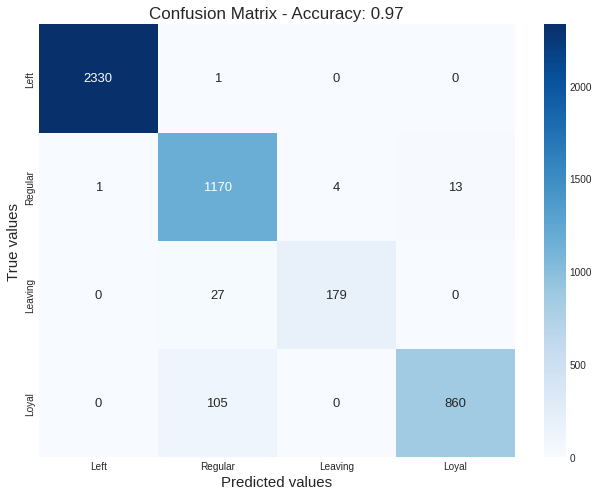

In [63]:
# show the confusion matrix of model buidling from RFM clusters

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y1_test, y1_pred)
score = accuracy_score(y1_test, y1_pred)

cm_df = pd.DataFrame(cm, columns = ['Left', 'Regular', 'Leaving', 'Loyal'], index=['Left', 'Regular', 'Leaving', 'Loyal'])

fig = plt.figure(figsize=(9,7))
ax = sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', annot_kws = {'fontsize' : 13})
ax.set_title('Confusion Matrix - Accuracy: %.2f'%score, fontsize=17)
ax.set_ylabel('True values', fontsize=15)
ax.set_xlabel('Predicted values', fontsize=15)
plt.tight_layout()
plt.show();

In [64]:
fig.savefig('Saved_models/confusion_matrix1.png', dpi=300, bbox_inches='tight')

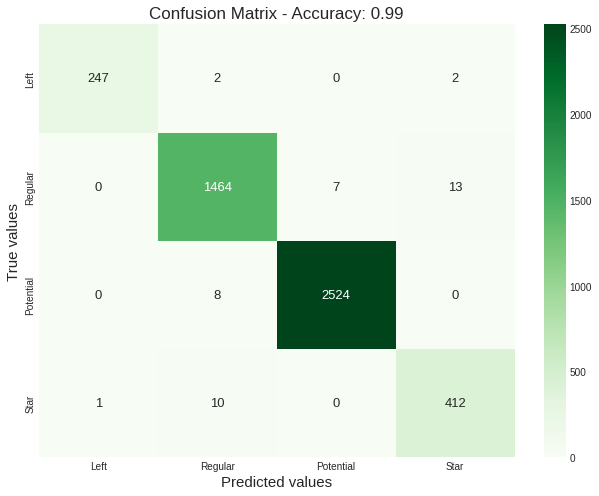

In [65]:
# show the confusion matrix of model buidling from Kmeans clusters

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y2_test, y2_pred)
score = accuracy_score(y2_test, y2_pred)

cm_df = pd.DataFrame(cm, 
                     columns = ['Left', 'Regular', 'Potential', 'Star'], 
                     index= ['Left', 'Regular', 'Potential', 'Star'])

fig = plt.figure(figsize=(9,7))
ax = sns.heatmap(cm_df, annot=True, fmt='g', cmap='Greens', annot_kws = {'fontsize' : 13})
ax.set_title('Confusion Matrix - Accuracy: %.2f'%score, fontsize=17)
ax.set_ylabel('True values', fontsize=15)
ax.set_xlabel('Predicted values', fontsize=15)
plt.tight_layout()
plt.show();

In [66]:
fig.savefig('Saved_models/confusion_matrix2.png', dpi=300, bbox_inches='tight')

# save models

In [67]:
# save model
from joblib import dump

dump(model1, 'Saved_models/DC_rmf.joblib')

dump(model2, 'Saved_models/DC_klabels.joblib')

['Saved_models/DC_klabels.joblib']